## Panel 3B in Bloniasz, Oyama, Stephen (2024)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from filtered_point_process.model import Model
from filtered_point_process.point_processes.filtered_point_process import FilteredPointProcess

Panel 1 dashed‐line x‐positions: -25.757, 0.000, 0.008, 25.764 Hz
Panel 2 dashed‐line x‐positions: -62.637, -28.481, 0.000, 0.008, 28.488, 62.645 Hz
Panel 3 dashed‐line x‐positions: -62.637, -28.481, 0.000, 0.008, 28.488, 62.645 Hz


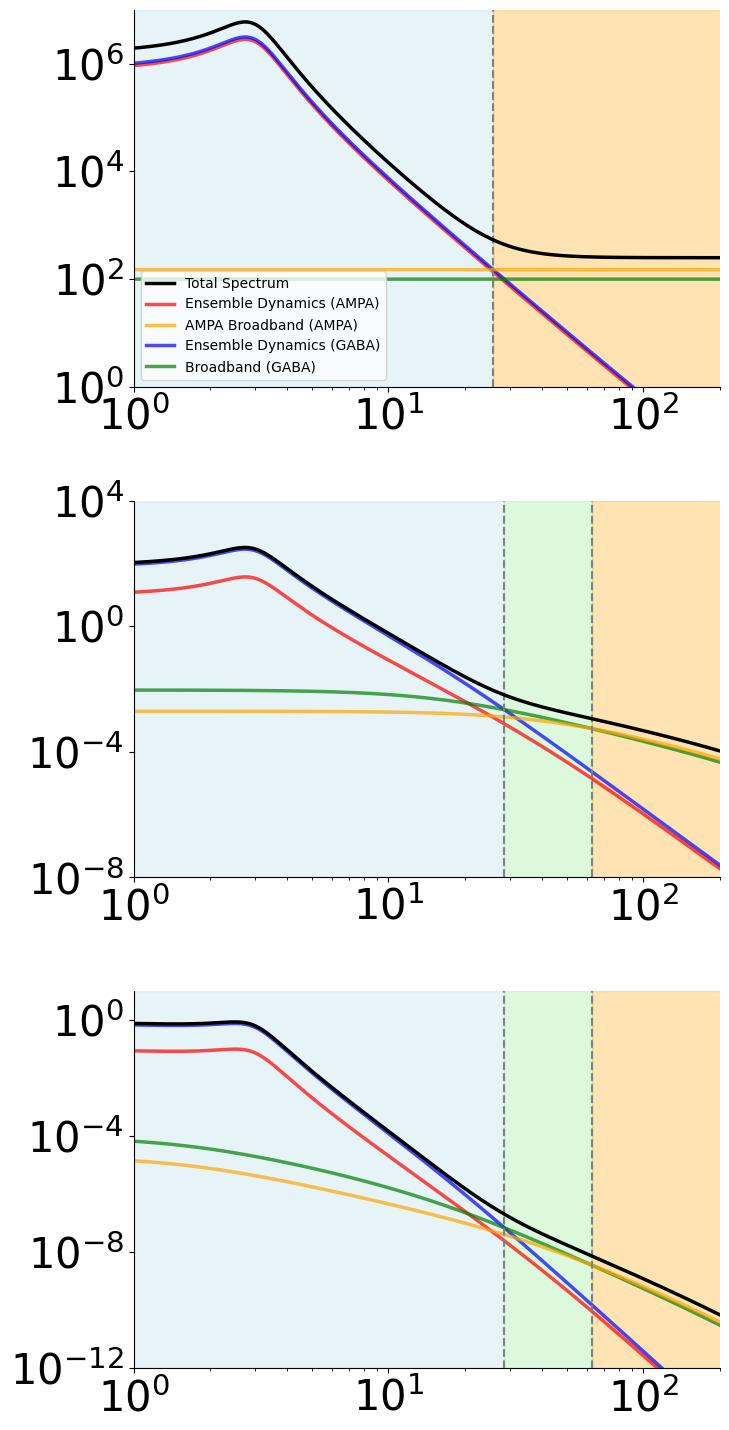

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from filtered_point_process.model import Model
from filtered_point_process.point_processes.filtered_point_process import FilteredPointProcess

# 1. Common simulation params
simulation_params = {
    "fs": 1000,
    "T": 5,
    "Nsims": 1,
    "simulate": False,
    "seed": 45
}

# 2. AMPA model + FPP
model_params_ampa = {
    "ar_coeffs": [1.9897557323136878, -0.9901],
    "white_noise_variance": 0.3,
    "lambda_0": [150]
}
ampa_model = Model("ar", model_params_ampa, simulation_params)
fpp_ampa = FilteredPointProcess(model=ampa_model,
                                filters={"AMPA": "AMPA", "1/f": "1/f"},
                                filter_params=None)
decomp_ampa    = fpp_ampa.decompositions[0]
pp_rate_ampa   = decomp_ampa["lambda_only"]
cif_ampa       = decomp_ampa["cif"]
total_pp_ampa  = pp_rate_ampa + cif_ampa
filters_ampa   = fpp_ampa.filter_instances

# 3. GABA model + FPP
model_params_gaba = {
    "ar_coeffs": [1.9897557323136878, -0.9901],
    "white_noise_variance": 0.315,
    "lambda_0": [100]
}
gaba_model = Model("ar", model_params_gaba, simulation_params)
fpp_gaba = FilteredPointProcess(model=gaba_model,
                                filters={"GABA": "GABA", "1/f": "1/f"},
                                filter_params=None)
decomp_gaba    = fpp_gaba.decompositions[0]
pp_rate_gaba   = decomp_gaba["lambda_only"]
cif_gaba       = decomp_gaba["cif"]
total_pp_gaba  = pp_rate_gaba + cif_gaba
filters_gaba   = fpp_gaba.filter_instances

# 4. Compute filtered spectra
k_gaba  = filters_gaba["GABA"].kernel_spectrum
k_1f    = filters_gaba["1/f"].kernel_spectrum
k_ampa  = filters_ampa["AMPA"].kernel_spectrum
k_1f_a  = filters_ampa["1/f"].kernel_spectrum

# Panel 1 (raw)
total_spectrum_1   = total_pp_gaba + total_pp_ampa
filtered_cif_1_a   = cif_ampa
filtered_cif_1_g   = cif_gaba
process_1_g        = pp_rate_gaba
process_1_a        = pp_rate_ampa

# Panel 2 (GABA filter)
total_spectrum_2   = (total_pp_gaba * k_gaba) + (total_pp_ampa * k_ampa)
filtered_cif_2_a   = cif_ampa * k_ampa
filtered_cif_2_g   = cif_gaba * k_gaba
process_2_g        = pp_rate_gaba * k_gaba
process_2_a        = pp_rate_ampa * k_ampa

# Panel 3 (GABA + 1/f)
total_spectrum_3   = (total_pp_gaba * k_gaba * k_1f) + (total_pp_ampa * k_ampa * k_1f_a)
filtered_cif_3_a   = cif_ampa * k_ampa * k_1f_a
filtered_cif_3_g   = cif_gaba * k_gaba * k_1f
process_3_g        = pp_rate_gaba * k_gaba * k_1f
process_3_a        = pp_rate_ampa * k_ampa * k_1f_a

frequencies = fpp_gaba.frequencies
fs_half     = simulation_params["fs"] / 2

# 5. Plotting helper with shading
def plot_spectra(ax, freqs, total, cif_a, cif_g, proc_g, proc_a, y_limits, legend_order=None):
    lines = [cif_a, cif_g, proc_g, proc_a]
    line_labels = ["Ensemble Dynamics (AMPA)", "Ensemble Dynamics (GABA)",
                   "Broadband (GABA)", "AMPA Broadband (AMPA)"]
    shading_colors = ["lightcoral", "lightblue", "lightgreen", "orange"]

    # plot each component
    for line, label, color in zip(lines, line_labels, ["red","blue","green","orange"]):
        ax.loglog(freqs, line, label=label, alpha=0.7, color=color, linewidth=2.5)

    # determine dominance
    dominant = np.argmax(np.vstack(lines), axis=0)
    cutoff  = np.searchsorted(freqs, fs_half)

    # shade regions
    start = 0
    for i in range(1, cutoff):
        if dominant[i] != dominant[start]:
            ax.axvspan(freqs[start], freqs[i],
                       color=shading_colors[dominant[start]], alpha=0.3, zorder=0)
            ax.axvline(x=freqs[i], color="gray", linestyle="--")
            start = i
    if start < cutoff:
        ax.axvspan(freqs[start], fs_half,
                   color=shading_colors[dominant[start]], alpha=0.3, zorder=0)

    # total spectrum on top
    ax.loglog(freqs[:cutoff], total[:cutoff],
              label="Total Spectrum", color="black", linewidth=2.5, zorder=6)

    # axes
    ax.set_xlim([1,200])
    ax.set_ylim(y_limits)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if legend_order:
        # collect handles in the order
        handles, labels = ax.get_legend_handles_labels()
        order = [labels.index(l) for l in legend_order]
        ax.legend([handles[i] for i in order], legend_order, loc="lower left")

# 6. Final plotting
plt.rcParams.update({
    "font.size": 30,
    "axes.titlesize": 30,
    "axes.labelsize": 30,
    "xtick.labelsize": 30,
    "ytick.labelsize": 30,
    "legend.fontsize": 10,
})
fig, axs = plt.subplots(3,1, figsize=(8,15))
legend_order = [
    "Total Spectrum",
    "Ensemble Dynamics (AMPA)",
    "AMPA Broadband (AMPA)",
    "Ensemble Dynamics (GABA)",
    "Broadband (GABA)"
]

plot_spectra(axs[0], frequencies,
             total_spectrum_1,
             filtered_cif_1_a, filtered_cif_1_g,
             process_1_g, process_1_a,
             [1,1e7], legend_order)

plot_spectra(axs[1], frequencies,
             total_spectrum_2,
             filtered_cif_2_a, filtered_cif_2_g,
             process_2_g, process_2_a,
             [1e-8,1e4], None)

plot_spectra(axs[2], frequencies,
             total_spectrum_3,
             filtered_cif_3_a, filtered_cif_3_g,
             process_3_g, process_3_a,
             [1e-12,1e1], None)

plt.tight_layout()

# Print dashed‐line x‐positions for each panel
for idx, (cif_a, cif_g, proc_g, proc_a) in enumerate([
    (filtered_cif_1_a, filtered_cif_1_g, process_1_g, process_1_a),
    (filtered_cif_2_a, filtered_cif_2_g, process_2_g, process_2_a),
    (filtered_cif_3_a, filtered_cif_3_g, process_3_g, process_3_a),
], start=1):
    lines    = [cif_a, cif_g, proc_g, proc_a]
    dominant = np.argmax(np.vstack(lines), axis=0)
    cutoff   = np.searchsorted(frequencies, fs_half)
    xs       = []
    start    = 0
    for i in range(1, cutoff):
        if dominant[i] != dominant[start]:
            xs.append(frequencies[i])
            start = i
    print(f"Panel {idx} dashed‐line x‐positions: {', '.join(f'{x:.3f}' for x in xs)} Hz")
    
plt.savefig('/Users/patrick_bloniasz/filtered-point-process/filtered_point_process/Notebooks/Figures_Bloniasz_et_al_2024/Figure_3B_PR.svg')
plt.savefig('/Users/patrick_bloniasz/filtered-point-process/filtered_point_process/Notebooks/Figures_Bloniasz_et_al_2024/Figure_3B_PR.png', dpi = 300)
plt.show()
